In [1]:
#Set up the ipython notebook
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd

#Load plotting package Basemap
#not included in gch4i
#conda install -c conda-forge basemap
from mpl_toolkits.basemap import Basemap

#Load netCDF
from netCDF4 import Dataset
import xarray as xr
import rioxarray #only needed if using tifs - note xarray will flip latitude [0,::-1,:]

In [2]:
data_path = '/Users/SCOFFIEL/Environmental Protection Agency (EPA)/Gridded CH4 Inventory - Documents/RTI 2024 Task Order/Task 2/ghgi_v3_working/'

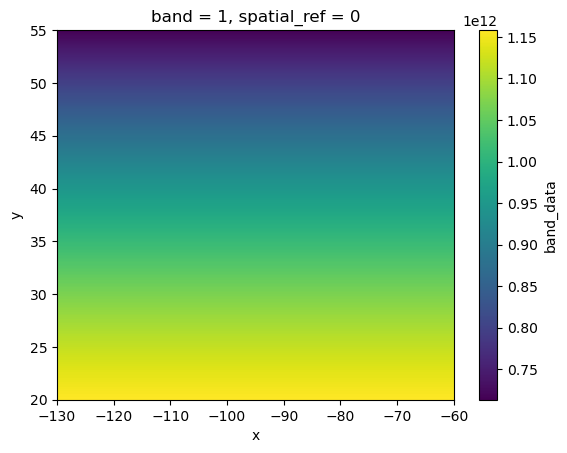

In [12]:
#v3 global file
areas = xr.open_dataset(data_path + '/v3_data/global/gridded_area_01_cm2.tif')
areas.band_data.plot()

#### Read EPA v2 outputs (2012)

In [13]:
#playing with v3 first ----------------
#v3 - which file/format to use? nc, tif, or kt per year tif?
#zeros vs NaNs matter?
v3_aban_coal = xr.open_dataset(data_path + '/v3_data/tmp/1b1a_abandoned_coal_ch4_emi_flux.nc')
v3_aban_coal
#note 0.05 offset in v3 so far

<xarray.Dataset> Size: 22MB
Dimensions:      (time: 11, lat: 350, lon: 700)
Coordinates:
  * time         (time) int64 88B 2012 2013 2014 2015 ... 2019 2020 2021 2022
  * lat          (lat) float64 3kB 20.0 20.1 20.2 20.3 ... 54.6 54.7 54.8 54.9
  * lon          (lon) float64 6kB -130.0 -129.9 -129.8 ... -60.3 -60.2 -60.1
Data variables:
    spatial_ref  int64 8B ...
    results      (time, lat, lon) float64 22MB ...

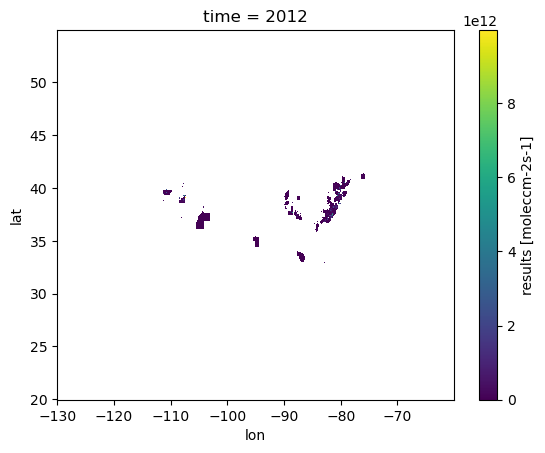

In [80]:
v3_aban_coal['results'].sel(time=2012).plot()

In [14]:
#v2 data 2012
EPA_2012 = xr.open_dataset(data_path + 'v3_data/Gridded_GHGI_Methane_v2_2012.nc')
EPA_2012

<xarray.Dataset> Size: 26MB
Dimensions:                                       (lat: 350, lon: 700, time: 1)
Coordinates:
  * lat                                           (lat) float32 1kB 20.05 ......
  * lon                                           (lon) float32 3kB -129.9 .....
  * time                                          (time) datetime64[ns] 8B 20...
Data variables: (12/27)
    emi_ch4_1A_Combustion_Mobile                  (time, lat, lon) float32 980kB ...
    emi_ch4_1A_Combustion_Stationary              (time, lat, lon) float32 980kB ...
    emi_ch4_1B1a_Abandoned_Coal                   (time, lat, lon) float32 980kB ...
    emi_ch4_1B1a_Surface_Coal                     (time, lat, lon) float32 980kB ...
    emi_ch4_1B1a_Underground_Coal                 (time, lat, lon) float32 980kB ...
    emi_ch4_1B2a_Petroleum_Systems_Exploration    (time, lat, lon) float32 980kB ...
    ...                                            ...
    emi_ch4_5A1_Landfills_Industrial              (time, lat, lon) float32 980kB ...
    emi_ch4_5A1_Landfills_MSW                     (time, lat, lon) float32 980kB ...
    emi_ch4_5B1_Composting                        (time, lat, lon) float32 980kB ...
    emi_ch4_5D_Wastewater_Treatment_Domestic      (time, lat, lon) float32 980kB ...
    emi_ch4_5D_Wastewater_Treatment_Industrial    (time, lat, lon) float32 980kB ...
    grid_cell_area                                (time, lat, lon) float32 980kB ...
Attributes:
    title:        Gridded U.S. Greenhouse Gas Inventory (Version 2): Annual m...
    publication:  A gridded inventory of annual 2012-2018 U.S. anthropogenic ...
    authors:      Joannes D. Maasakkers, Erin E. McDuffie, Melissa P. Sulpriz...
    history:      September 10, 2023
    conventions:  COARDS
    version:      1.0 - Publication version (Data equals the preprint version)
    contact:      J.D.Maasakkers@sron.nl and McDuffie.Erin.E@epa.gov
    year:         2012

Text(0.5, 1.0, 'Grid cell area (km2)')

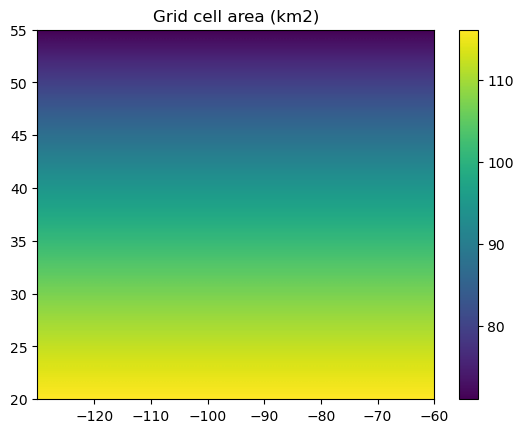

In [30]:
Lat = EPA_2012.lat.values
Lon = EPA_2012.lon.values

area_matrix = EPA_2012.grid_cell_area[0,:,:]
area_matrix_km2 = area_matrix/100000/100000
EPA_2012 = EPA_2012.drop_vars('grid_cell_area') #26 source variables left

plt.pcolormesh(Lon, Lat, area_matrix_km2)
plt.colorbar()
plt.title('Grid cell area (km2)')

In [41]:
sources = list(EPA_2012.keys())
#sources = ['_'.join(s.split('_')[2:]) for s in sources] #take off emi_ch4_
sources

['emi_ch4_1A_Combustion_Mobile',
 'emi_ch4_1A_Combustion_Stationary',
 'emi_ch4_1B1a_Abandoned_Coal',
 'emi_ch4_1B1a_Surface_Coal',
 'emi_ch4_1B1a_Underground_Coal',
 'emi_ch4_1B2a_Petroleum_Systems_Exploration',
 'emi_ch4_1B2a_Petroleum_Systems_Production',
 'emi_ch4_1B2a_Petroleum_Systems_Refining',
 'emi_ch4_1B2a_Petroleum_Systems_Transport',
 'emi_ch4_1B2ab_Abandoned_Oil_Gas',
 'emi_ch4_1B2b_Natural_Gas_Distribution',
 'emi_ch4_1B2b_Natural_Gas_Exploration',
 'emi_ch4_1B2b_Natural_Gas_Processing',
 'emi_ch4_1B2b_Natural_Gas_Production',
 'emi_ch4_1B2b_Natural_Gas_TransmissionStorage',
 'emi_ch4_2B8_Industry_Petrochemical',
 'emi_ch4_2C2_Industry_Ferroalloy',
 'emi_ch4_3A_Enteric_Fermentation',
 'emi_ch4_3B_Manure_Management',
 'emi_ch4_3C_Rice_Cultivation',
 'emi_ch4_3F_Field_Burning',
 'emi_ch4_5A1_Landfills_Industrial',
 'emi_ch4_5A1_Landfills_MSW',
 'emi_ch4_5B1_Composting',
 'emi_ch4_5D_Wastewater_Treatment_Domestic',
 'emi_ch4_5D_Wastewater_Treatment_Industrial']

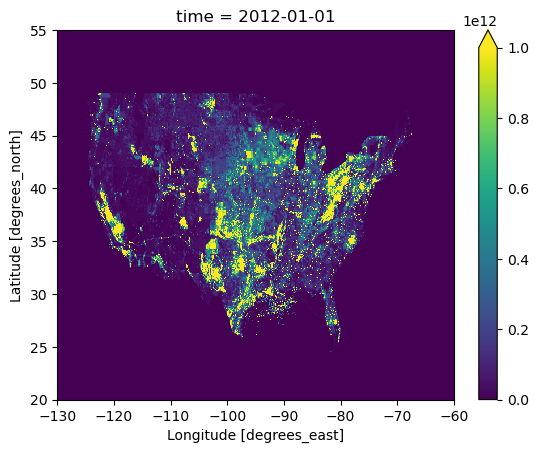

In [58]:
#summed emissions
EPA_v2 = EPA_2012[sources].to_array().sum("variable")[0,:,:]
EPA_v2.plot(vmin=0, vmax=1e12)

In [59]:
#was Bram just taking the first entry in time, 2012, from EPA?

In [60]:
Avagrado   = 6.02214129 * 10**(23)  #molecules/mol
Molarch4   = 16.04 #g/mol
#print('Budget: ', np.sum(EPA_v2[:,:,0] / float(10**12 * Avagrado) * Molarch4 * 365 * 24 * 60 * 60 * area_matrix), ' tg') #25.62565822114809  tg
print('Budget: ', np.sum(EPA_v2 / float(10**12 * Avagrado) * Molarch4 * 365 * 24 * 60 * 60 * area_matrix), ' tg')

Budget:  <xarray.DataArray ()> Size: 4B
array(25.625662, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2012-01-01  tg


###### Read EDF

In [61]:
#Initialze EDF
Barnettflag   = np.zeros([len(Lat),len(Lon)])

EDF_1A_mob   = np.zeros([len(Lat),len(Lon)])
EDF_1A_2   = np.zeros([len(Lat),len(Lon)])
EDF_2   = np.zeros([len(Lat),len(Lon)])

EDF_1B2a = np.zeros([len(Lat),len(Lon)])
EDF_1B2b = np.zeros([len(Lat),len(Lon)])

EDF_1B2b_prod = np.zeros([len(Lat),len(Lon)])
EDF_1B2b_proc = np.zeros([len(Lat),len(Lon)])
EDF_1B2b_tran = np.zeros([len(Lat),len(Lon)])
EDF_1B2b_dist = np.zeros([len(Lat),len(Lon)])

EDF_4AB = np.zeros([len(Lat),len(Lon)])

EDF_6A = np.zeros([len(Lat),len(Lon)])
EDF_6B = np.zeros([len(Lat),len(Lon)])

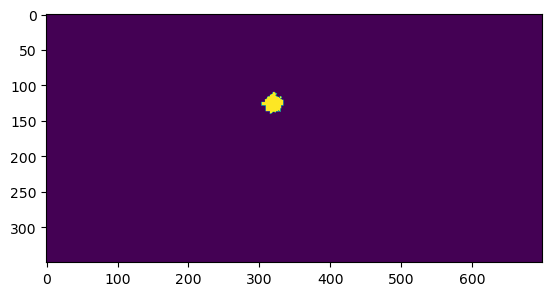

In [63]:
temp_f = xr.open_dataset('/Users/SCOFFIEL/OneDrive - Environmental Protection Agency (EPA)/Gridding/Errors_v3/Data_EDF/EDF_All.nc')
#We just need the Barnett flag from this file
Barnettflag[100:-200,280:-350] += np.array(temp_f.variables['flux_total'])
Barnettflag[Barnettflag>1] = 1
plt.imshow(Barnettflag) #upside down
temp_f.close()

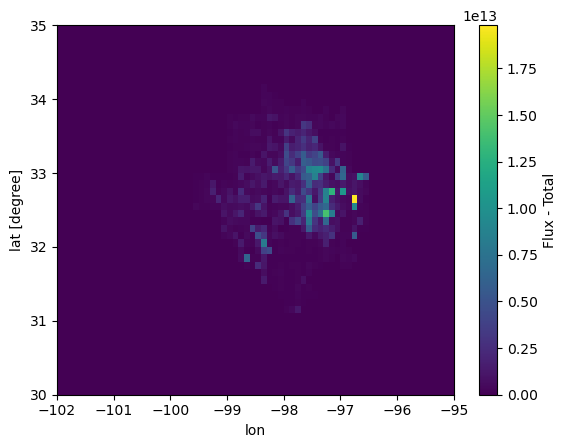

In [64]:
temp_f.flux_total.plot()

Text(0.5, 1.0, 'Barnett flag')

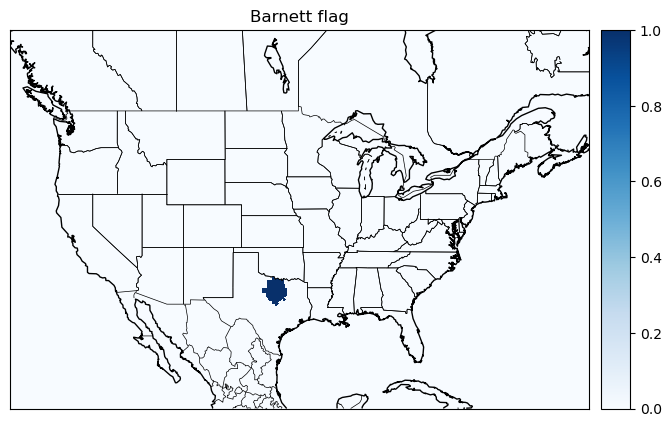

In [65]:
fig = plt.figure(figsize=(8,8))
m = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=55,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='l', 
           area_thresh=10000)
m.drawstates()
m.drawcoastlines()
m.drawcountries()

x,y = np.meshgrid(Lon, Lat)
x,y = m(x, y)
my_cmap = plt.get_cmap('Blues')
#my_cmap.set_under('white')
cs = m.pcolormesh(x, y, Barnettflag, cmap = my_cmap, vmin=0, vmax=1)
m.colorbar(cs)#, extend = 'min')
plt.title('Barnett flag')

In [66]:
temp_f = xr.open_dataset('/Users/SCOFFIEL/OneDrive - Environmental Protection Agency (EPA)/Gridding/Errors_v3/Data_EDF/EDF_All_Update.nc')
EDF_1A_mob[100:-200,280:-350]        += np.array(temp_f.variables['flux_combustion_mobile'])
EDF_2[100:-200,280:-350]        += np.array(temp_f.variables['flux_industry'])

EDF_1A_2[100:-200,280:-350]        += np.array(temp_f.variables['flux_combustion_mobile'])
EDF_1A_2[100:-200,280:-350]        += np.array(temp_f.variables['flux_industry'])

EDF_1B2a[100:-200,280:-350]      += np.array(temp_f.variables['flux_petroleum'])

EDF_1B2b[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_production'])
EDF_1B2b[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_processing'])
EDF_1B2b[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_transmission'])
EDF_1B2b[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_distribution'])

EDF_1B2b_prod[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_production'])
EDF_1B2b_proc[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_processing'])
EDF_1B2b_tran[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_transmission'])
EDF_1B2b_dist[100:-200,280:-350] += np.array(temp_f.variables['flux_gas_distribution'])

EDF_4AB[100:-200,280:-350]        += np.array(temp_f.variables['flux_livestock'])

EDF_6A[100:-200,280:-350]        += np.array(temp_f.variables['flux_waste_landfills'])
EDF_6B[100:-200,280:-350]        += np.array(temp_f.variables['flux_waste_wastewater'])
temp_f.close()

Text(0.5, 1.0, 'EDF_1B2b')

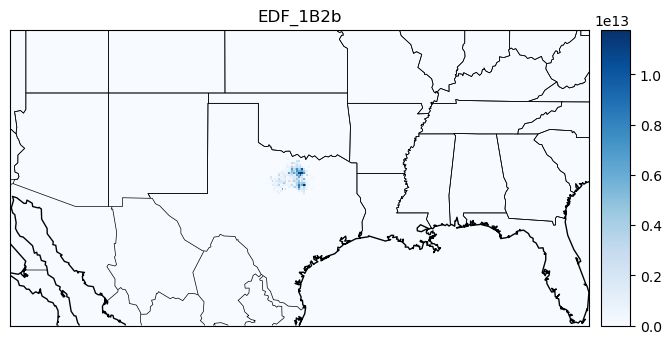

In [67]:
fig = plt.figure(figsize=(8,8))
m = Basemap(projection='merc',llcrnrlat=25,urcrnrlat=40,\
            llcrnrlon=-115,urcrnrlon=-80,lat_ts=20,resolution='l', 
           area_thresh=10000)
m.drawstates()
m.drawcoastlines()
m.drawcountries()

x,y = np.meshgrid(Lon, Lat)
x,y = m(x, y)
my_cmap = plt.get_cmap('Blues')
#my_cmap.set_under('white')
cs = m.pcolormesh(x, y, EDF_1B2b, cmap = my_cmap)#, vmin=0, vmax=1)
m.colorbar(cs)#, extend = 'min')
plt.title('EDF_1B2b')

#### Error Optimization

In [68]:
def costf(x0, EPA_in, EDF_in, FLAG_in, inres):  
    #Only consider the Barnett
    EPA_in[FLAG_in == 0] = 0
    EDF_in[FLAG_in == 0] = 0
    
    Error_field = np.zeros([EPA_in.shape[0],EPA_in.shape[1]])
    Error_field = x0 * EPA_in
    
    #Calculate the true error
    True_err = np.abs(EDF_in-EPA_in)
    
    #Basic absolute cost function
    cost_array = (Error_field[FLAG_in>0]-True_err[FLAG_in>0])**2
    cost       = np.sum(cost_array)
    
    return cost

In [69]:
def cost_explore(EPA_in, EDF_in,FLAG_through,titlestring,national_alpha,res):   

    xi = np.arange(national_alpha,2.0,0.01) #Set resolution to a lower value for a better grid search
        
    cost_array = np.zeros([len(xi)])

    for i in np.arange(len(xi)):
        cost_array[i] = costf(xi[i],EPA_in,EDF_in,FLAG_through,res)

    x_i = xi[np.where(cost_array == np.min(cost_array))[0][0]]
    
    print('Scaling: ', x_i)
    
    return(x_i)

In [70]:
def error_res(EPA_in,EDF_in,titlestring,national_alpha):
    print(' ')
    print(titlestring)
    
    #Creat clean emission arrays
    EPA1 = np.zeros([EPA_in.shape[0],EPA_in.shape[1]]); EDF1 = np.zeros([EPA_in.shape[0],EPA_in.shape[1]]); FLA1 = np.zeros([EPA_in.shape[0],EPA_in.shape[1]])
    
    #Clean up emissions
    for i in np.arange(EPA1.shape[0]):
        for j in np.arange(EPA1.shape[1]):
            EDF1[i,j] = np.sum(EDF_in[i,j])
            EPA1[i,j] = np.sum(EPA_in[i,j])
            FLA1[i,j] = np.sum(Barnettflag[i,j])

    FLA1[FLA1 < 1] = 0; FLA1[FLA1 > 0] = 1
    
    print('.1')
    err_one = cost_explore(EPA1,EDF1,FLA1,titlestring,national_alpha,0.1)  
    
    Lon_2 = np.arange(-129.9,-60.1+0.2,0.2)
    Lat_2 = np.arange(20.1,54.9+0.2,0.2)
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); EDF2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)):
        for j in np.arange(len(Lon_2)):
            EDF2[i,j] = np.sum(EDF_in[i*2:(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[i*2:(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])
            FLA2[i,j] = np.sum(Barnettflag[i*2:(i+1)*2,j*2:(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1    
    
    print('.2')
    err_two_1 = cost_explore(EPA2,EDF2,FLA2,titlestring,national_alpha,0.2)
    
    
    #2
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); EDF2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            EDF2[i,j] = np.sum(EDF_in[1+i*2:1+(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[1+i*2:1+(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])
            FLA2[i,j] = np.sum(Barnettflag[1+i*2:1+(i+1)*2,j*2:(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1
    
    err_two_2 = cost_explore(EPA2,EDF2,FLA2,titlestring,national_alpha,0.2)
 
    #3
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); EDF2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            EDF2[i,j] = np.sum(EDF_in[i*2:(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[i*2:(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])
            FLA2[i,j] = np.sum(Barnettflag[i*2:(i+1)*2,1+j*2:1+(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1   
    
    err_two_3 = cost_explore(EPA2,EDF2,FLA2,titlestring,national_alpha,0.2)
    
    #4
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); EDF2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            EDF2[i,j] = np.sum(EDF_in[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])
            FLA2[i,j] = np.sum(Barnettflag[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1   
    
    err_two_4 = cost_explore(EPA2,EDF2,FLA2,titlestring,national_alpha,0.2)
    
    #1
    Lon_3 = np.arange(-129.85,-60.15+0.3,0.3)
    Lat_3 = np.arange(20.15,54.85+0.3,0.3)
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); EDF3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            EDF3[i,j] = np.sum(EDF_in[i*3:(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[i*3:(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])
            FLA3[i,j] = np.sum(Barnettflag[i*3:(i+1)*3,j*3:(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    print('.3')
    err_thr_1 = cost_explore(EPA3,EDF3,FLA3,titlestring,national_alpha,0.3)
    
    #2
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); EDF3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            EDF3[i,j] = np.sum(EDF_in[1+i*3:1+(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[1+i*3:1+(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])
            FLA3[i,j] = np.sum(Barnettflag[1+i*3:1+(i+1)*3,j*3:(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    err_thr_2 = cost_explore(EPA3,EDF3,FLA3,titlestring,national_alpha,0.3)    
  
    #3
    Lon_3 = np.arange(-129.85,-60.15+0.3,0.3)
    Lat_3 = np.arange(20.15,54.85+0.3,0.3)
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); EDF3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            EDF3[i,j] = np.sum(EDF_in[i*3:(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[i*3:(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])
            FLA3[i,j] = np.sum(Barnettflag[i*3:(i+1)*3,1+j*3:1+(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    err_thr_3 = cost_explore(EPA3,EDF3,FLA3,titlestring,national_alpha,0.3)
    
    #4
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); EDF3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            EDF3[i,j] = np.sum(EDF_in[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])
            FLA3[i,j] = np.sum(Barnettflag[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    err_thr_4 = cost_explore(EPA3,EDF3,FLA3,titlestring,national_alpha,0.3)        
      
    
    
    Lon_4 = np.arange(-129.8,-60.2+0.4,0.4)
    Lat_4 = np.arange(20.2,54.8+0.4,0.4)
    
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); EDF4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)):
        for j in np.arange(len(Lon_4)):
            EDF4[i,j] = np.sum(EDF_in[i*4:(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[i*4:(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])
            FLA4[i,j] = np.sum(Barnettflag[i*4:(i+1)*4,j*4:(j+1)*4])
 
    FLA4[FLA4 < 4] = 0; FLA4[FLA4 > 0] = 1     
    
    print('.4')
    err_four_1 = cost_explore(EPA4,EDF4,FLA4,titlestring,national_alpha,0.4)
    
    #2
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); EDF4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)-1):
        for j in np.arange(len(Lon_4)-1):
            EDF4[i,j] = np.sum(EDF_in[i*4:(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[i*4:(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])
            FLA4[i,j] = np.sum(Barnettflag[i*4:(i+1)*4,1+j*4:1+(j+1)*4])
 
    FLA4[FLA4 < 4] = 0
    FLA4[FLA4 > 0] = 1
    
    err_four_2 = cost_explore(EPA4,EDF4,FLA4,titlestring,national_alpha,0.4)
    
    #3
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); EDF4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)-1):
        for j in np.arange(len(Lon_4)-1):
            EDF4[i,j] = np.sum(EDF_in[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])
            FLA4[i,j] = np.sum(Barnettflag[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])
 
    FLA4[FLA4 < 4] = 0
    FLA4[FLA4 > 0] = 1
    
    err_four_3 = cost_explore(EPA4,EDF4,FLA4,titlestring,national_alpha,0.4)
    
    #4   
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); EDF4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)-1):
        for j in np.arange(len(Lon_4)-1):
            EDF4[i,j] = np.sum(EDF_in[1+i*4:1+(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[1+i*4:1+(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])
            FLA4[i,j] = np.sum(Barnettflag[1+i*4:1+(i+1)*4,j*4:(j+1)*4])
 
    FLA4[FLA4 < 4] = 0
    FLA4[FLA4 > 0] = 1
    
    err_four_4 = cost_explore(EPA4,EDF4,FLA4,titlestring,national_alpha,0.4)
    
    
    #1
    Lon_5 = np.arange(-129.75,-60.25+0.5,0.5)
    Lat_5 = np.arange(20.25,54.75+0.5,0.5)
    
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); EDF5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 
 
    for i in np.arange(len(Lat_5)):
        for j in np.arange(len(Lon_5)):
            EDF5[i,j] = np.sum(EDF_in[i*5:(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[i*5:(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])
            FLA5[i,j] = np.sum(Barnettflag[i*5:(i+1)*5,j*5:(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
    
    print('.5')
    err_five_1 = cost_explore(EPA5,EDF5,FLA5,titlestring,national_alpha,0.5)
  
    #2
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); EDF5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 
 
    for i in np.arange(len(Lat_5)-1):
        for j in np.arange(len(Lon_5)-1):
            EDF5[i,j] = np.sum(EDF_in[i*5:(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[i*5:(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])
            FLA5[i,j] = np.sum(Barnettflag[i*5:(i+1)*5,1+j*5:1+(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
        
    err_five_2 = cost_explore(EPA5,EDF5,FLA5,titlestring,national_alpha,0.5)
    
    #3
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); EDF5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 

    for i in np.arange(len(Lat_5)-1):
        for j in np.arange(len(Lon_5)-1):
            EDF5[i,j] = np.sum(EDF_in[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])
            FLA5[i,j] = np.sum(Barnettflag[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
       
    err_five_3 = cost_explore(EPA5,EDF5,FLA5,titlestring,national_alpha,0.5)
    
    #4
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); EDF5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 
 
    for i in np.arange(len(Lat_5)-1):
        for j in np.arange(len(Lon_5)-1):
            EDF5[i,j] = np.sum(EDF_in[1+i*5:1+(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[1+i*5:1+(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])
            FLA5[i,j] = np.sum(Barnettflag[1+i*5:1+(i+1)*5,j*5:(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
    
    err_five_4 = cost_explore(EPA5,EDF5,FLA5,titlestring,national_alpha,0.5)
    
    resol   = np.array([0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5])
    err_alph = np.array([err_one,err_one,err_one,err_one,err_two_1,err_two_2,err_two_3,err_two_4,err_thr_1,err_thr_2,err_thr_3,err_thr_4,err_four_1,err_four_2,err_four_3,err_four_4,err_five_1,err_five_2,err_five_3,err_five_4])

    return(resol,err_alph)

In [ ]:
#PICK UP HERE - EPA SUM, EDF SUM, time dimension deletion? [:,:,0]

In [12]:
#Put in national emissions (using the latest inventory year)
#All of this is hardcoded as there isn't a single table with uncertainties
#We need to combine sectors because CALGEM/EDF don't have the same splits

tot_nat_1B2a = 1449
tot_nat_1B2b = 5598
tot_nat_4AB_4A = 7103
tot_nat_4AB_4B = 2467
tot_nat_4AB = tot_nat_4AB_4A + tot_nat_4AB_4B
tot_nat_6A_Mun = 3823
tot_nat_6A_Ind = 599
tot_nat_6A   = tot_nat_6A_Mun+tot_nat_6A_Ind
tot_nat_6B_Dom = 334
tot_nat_6B_Ind = 235
tot_nat_6B   = tot_nat_6B_Dom + tot_nat_6B_Ind

#Precalculate enteric & manure national errors
enteric_error = (0.11+0.18)/2.
manure_error  = (0.18+0.20)/2.

#Precalculate domestic & industrial wastewater national errors
lf_mun_error  = (0.25+0.25)/2.
lf_ind_error  = (0.31+0.25)/2.

#Precalculate domestic & industrial wastewater national errors
ww_dom_error  = (0.28+0.22)/2.
ww_ind_error  = (0.48+0.50)/2.

#Define national level alphas
alph_nat_1B2a = (0.31+0.34)/2.
alph_nat_1B2b = (0.15+0.15)/2.
alph_nat_4AB  = (enteric_error*tot_nat_4AB_4A + manure_error*tot_nat_4AB_4B)/tot_nat_4AB
alph_nat_6A   = (lf_mun_error*tot_nat_6A_Mun + lf_ind_error*tot_nat_6A_Ind)/tot_nat_6A
alph_nat_6B   = (ww_dom_error*tot_nat_6B_Dom + ww_ind_error*tot_nat_6B_Ind)/tot_nat_6B

#For Calgem
alph_nat_1B2ab = (alph_nat_1B2a*tot_nat_1B2a + alph_nat_1B2b*tot_nat_1B2b)/(tot_nat_1B2a+tot_nat_1B2b)

#Calculate sums
EPA_sum = EPA_v2_1B2a_Petroleum_Systems_Exploration + EPA_v2_1B2a_Petroleum_Systems_Production + EPA_v2_1B2a_Petroleum_Systems_Refining + EPA_v2_1B2a_Petroleum_Systems_Transport + EPA_v2_1B2b_Natural_Gas_Production + EPA_v2_1B2b_Natural_Gas_Distribution + EPA_v2_1B2b_Natural_Gas_Exploration + EPA_v2_1B2b_Natural_Gas_Processing + EPA_v2_1B2b_Natural_Gas_TransmissionStorage + EPA_v2_3A_Enteric_Fermentation + EPA_v2_3B_Manure_Management + EPA_v2_5A1_Landfills_Industrial + EPA_v2_5A1_Landfills_MSW + EPA_v2_5D_Wastewater_Treatment_Domestic + EPA_v2_5D_Wastewater_Treatment_Industrial
EDF_sum = EDF_1B2a + EDF_1B2b + EDF_4AB + EDF_6A + EDF_6B

EPA_Gas = EPA_v2_1B2b_Natural_Gas_Distribution + EPA_v2_1B2b_Natural_Gas_Exploration + EPA_v2_1B2b_Natural_Gas_Processing + EPA_v2_1B2b_Natural_Gas_Production + EPA_v2_1B2b_Natural_Gas_TransmissionStorage
EPA_v2_1B2a_Petroleum_Systems = EPA_v2_1B2a_Petroleum_Systems_Exploration + EPA_v2_1B2a_Petroleum_Systems_Production + EPA_v2_1B2a_Petroleum_Systems_Refining + EPA_v2_1B2a_Petroleum_Systems_Transport

alph_nat_sum = np.sqrt((alph_nat_1B2a*tot_nat_1B2a)**2 + (alph_nat_1B2b*tot_nat_1B2b)**2 + (alph_nat_4AB*tot_nat_4AB)**2 + (alph_nat_6A*tot_nat_6A)**2 + (alph_nat_6B*tot_nat_6B)**2)/float(tot_nat_1B2a+tot_nat_1B2b+tot_nat_4AB+tot_nat_6A+tot_nat_6B)

In [13]:
Avagrado   = 6.02214129 * 10**(23)  #molecules/mol
Molarch4   = 16.04 #g/mol
print('Budget:      ', np.sum(EPA_v2[:,:,0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix), ' tg')
print('Budget here: ', np.sum(EPA_sum[:,:,0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix), ' tg')
print('Budget here Barnett: ', np.sum(EPA_sum[Barnettflag>0,0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix[Barnettflag>0]), ' tg')
print('Budget EDF:  ', np.sum(EDF_sum[:,:] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix), ' tg')

print('Oil EDF Barnett: ', np.sum(EDF_1B2a[Barnettflag>0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix[Barnettflag>0]), ' tg')
print('Oil EPA Barnett: ', np.sum(EPA_v2_1B2a_Petroleum_Systems[Barnettflag>0,0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix[Barnettflag>0]), ' tg')
print('Gas EDF Barnett: ', np.sum(EDF_1B2b[Barnettflag>0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix[Barnettflag>0]), ' tg')
print('Gas EPA Barnett: ', np.sum(EPA_Gas[Barnettflag>0,0] / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix[Barnettflag>0]), ' tg')

Budget:       25.695865460998398  tg
Budget here:  21.31425813327788  tg
Budget here Barnett:  0.5427820353756809  tg
Budget EDF:   0.7261711074270828  tg
Oil EDF Barnett:  0.03911560290846268  tg
Oil EPA Barnett:  0.04357563610412624  tg
Gas EDF Barnett:  0.4731747377876412  tg
Gas EPA Barnett:  0.2798776146353116  tg


In [14]:
print('Analyze errors for multiple resolutions with basic cost function')
resol, alph_1B2a   = error_res(EPA_v2_1B2a_Petroleum_Systems[:,:,0],EDF_1B2a,     'PT systems',      alph_nat_1B2a)
resol, alph_1B2b   = error_res(EPA_Gas[:,:,0],EDF_1B2b,     'NG systems',      alph_nat_1B2b)
resol, alph_4AB    = error_res(EPA_v2_3A_Enteric_Fermentation[:,:,0] + EPA_v2_3B_Manure_Management[:,:,0],EDF_4AB,       'Livestock',       alph_nat_4AB)
resol, alph_6A     = error_res(EPA_v2_5A1_Landfills_Industrial[:,:,0] + EPA_v2_5A1_Landfills_MSW[:,:,0],EDF_6A,         'Landfills',       alph_nat_6A)
resol, alph_6B     = error_res(EPA_v2_5D_Wastewater_Treatment_Domestic[:,:,0] + EPA_v2_5D_Wastewater_Treatment_Industrial[:,:,0],EDF_6B,         'Wastewater',      alph_nat_6B)
resol, alph_sum    = error_res(EPA_sum[:,:,0],EDF_sum,       'Sum',             alph_nat_sum) #[We don't really use this]

Analyze errors for multiple resolutions with basic cost function
 
PT systems
.1
Scaling:  0.7250000000000003
.2
Scaling:  0.6350000000000002
Scaling:  0.6950000000000003
Scaling:  0.6250000000000002
Scaling:  0.7150000000000003
.3
Scaling:  0.6250000000000002
Scaling:  0.5650000000000002
Scaling:  0.6450000000000002
Scaling:  0.6050000000000002
.4
Scaling:  0.6650000000000003
Scaling:  0.6750000000000003
Scaling:  0.6450000000000002
Scaling:  0.6650000000000003
.5
Scaling:  0.5550000000000002
Scaling:  0.5650000000000002
Scaling:  0.6350000000000002
Scaling:  0.7050000000000003
 
NG systems
.1
Scaling:  0.6100000000000004
.2
Scaling:  0.6200000000000004
Scaling:  0.5900000000000004
Scaling:  0.5600000000000004
Scaling:  0.5700000000000004
.3
Scaling:  0.5600000000000004
Scaling:  0.5300000000000004
Scaling:  0.5700000000000004
Scaling:  0.5400000000000004
.4
Scaling:  0.5200000000000004
Scaling:  0.4700000000000003
Scaling:  0.5900000000000004
Scaling:  0.5900000000000004
.5
Scaling: 

#### Fit a resolution-dependent funciton through the results

In [15]:
#Define the functions we are going to fit
Alph_function = lambda res, alph_in_0, alph_in_lam : np.exp(-(res-0.1)*np.abs(alph_in_lam)) * alph_in_0 + alph_national
Alph_function_p = lambda res, alph_in_0, alph_in_lam, alpha_nat: np.exp(-(res-0.1)*np.abs(alph_in_lam)) * alph_in_0 + alpha_nat

#### Weighing all resolutions equally

In [16]:
resol_s = np.array([np.mean(resol[0:4]),np.mean(resol[4:8]),np.mean(resol[8:12]),np.mean(resol[12:16]),np.mean(resol[16:])])
alph_1B2a_s = np.array([np.mean(alph_1B2a[0:4]),np.mean(alph_1B2a[4:8]),np.mean(alph_1B2a[8:12]),np.mean(alph_1B2a[12:16]),np.mean(alph_1B2a[16:])])
alph_1B2b_s = np.array([np.mean(alph_1B2b[0:4]),np.mean(alph_1B2b[4:8]),np.mean(alph_1B2b[8:12]),np.mean(alph_1B2b[12:16]),np.mean(alph_1B2b[16:])])
alph_4AB_s = np.array([np.mean(alph_4AB[0:4]),np.mean(alph_4AB[4:8]),np.mean(alph_4AB[8:12]),np.mean(alph_4AB[12:16]),np.mean(alph_4AB[16:])])
alph_6A_s = np.array([np.mean(alph_6A[0:4]),np.mean(alph_6A[4:8]),np.mean(alph_6A[8:12]),np.mean(alph_6A[12:16]),np.mean(alph_6A[16:])])
alph_6B_s = np.array([np.mean(alph_6B[0:4]),np.mean(alph_6B[4:8]),np.mean(alph_6B[8:12]),np.mean(alph_6B[12:16]),np.mean(alph_6B[16:])])
alph_sum_s = np.array([np.mean(alph_sum[0:4]),np.mean(alph_sum[4:8]),np.mean(alph_sum[8:12]),np.mean(alph_sum[12:16]),np.mean(alph_sum[16:])])

alph_national = alph_nat_1B2a
alph_par_1B2a = sp.optimize.curve_fit(Alph_function,resol_s,alph_1B2a_s)[0]
print('Petroleum - Alpha', alph_par_1B2a[0:])

alph_national = alph_nat_1B2b
alph_par_1B2b = sp.optimize.curve_fit(Alph_function,resol_s,alph_1B2b_s)[0]
print('Natural Gas - Alpha', alph_par_1B2b[0:])

alph_national = alph_nat_4AB
alph_par_4AB = sp.optimize.curve_fit(Alph_function,resol_s,alph_4AB_s)[0]
print('Livestock - Alpha', alph_par_4AB[0:])

alph_national = alph_nat_6A
alph_par_6A = sp.optimize.curve_fit(Alph_function,resol_s,alph_6A_s)[0]
print('Landfills - Alpha', alph_par_6A[0:])

alph_national = alph_nat_6B
alph_par_6B = sp.optimize.curve_fit(Alph_function,resol_s,alph_6B_s)[0]
print( 'Wastewater - Alpha', alph_par_6B[0:])

alph_national = alph_nat_sum
alph_par_sum = sp.optimize.curve_fit(Alph_function,resol_s,alph_sum_s)[0]
print( 'Sum - Alpha', alph_par_sum[0:])

Petroleum - Alpha [0.37934871 0.70763461]
Natural Gas - Alpha [0.43958538 0.12857142]
Livestock - Alpha [0.87959479 3.1239247 ]
Landfills - Alpha [0.19002886 4.01648796]
Wastewater - Alpha [ 0.32080662 10.85842226]
Sum - Alpha [0.41914014 1.19413171]


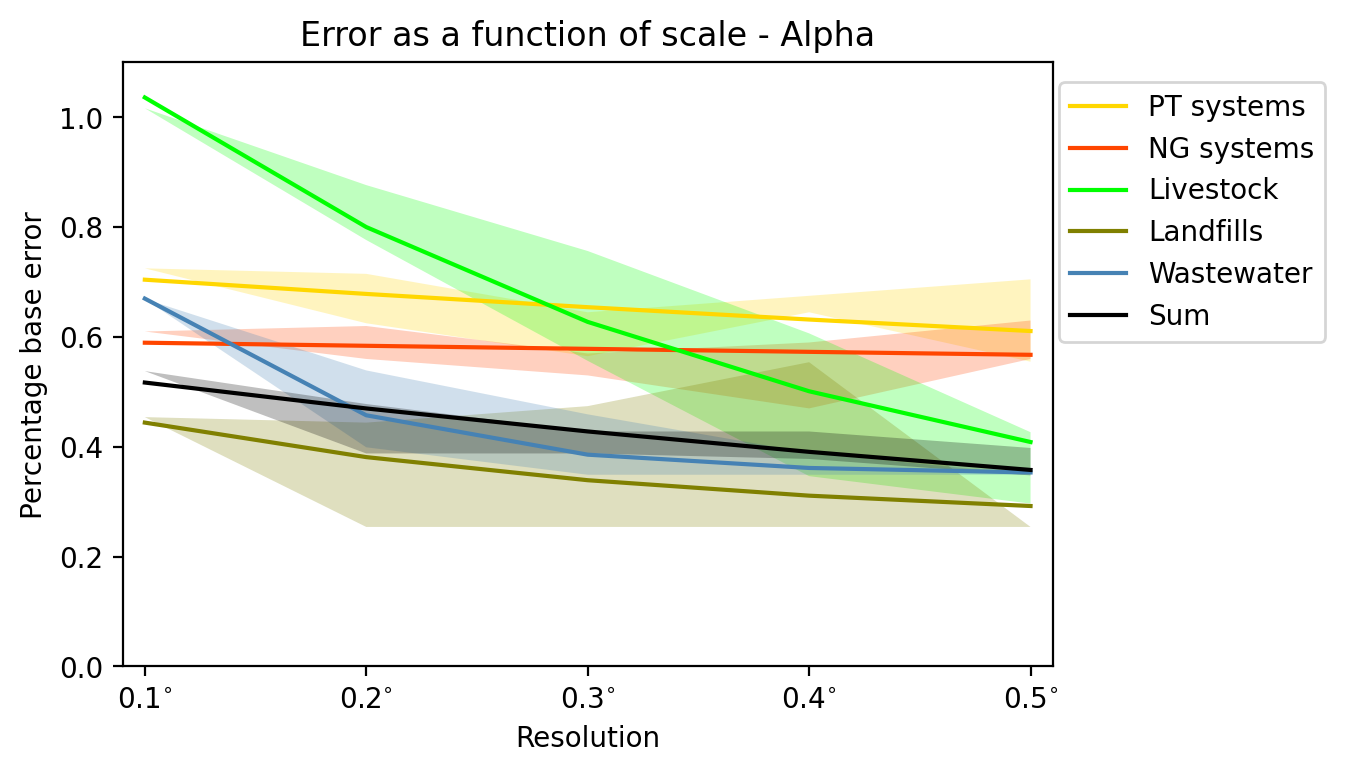

In [17]:
#Visualize the fits and ranges of the different regriddings

resol_fill = np.array([np.max(resol[0:4]),np.max(resol[4:8]),np.max(resol[8:12]),np.max(resol[12:16]),np.max(resol[16:])])

alph_1B2a_u = np.array([np.max(alph_1B2a[0:4]),np.max(alph_1B2a[4:8]),np.max(alph_1B2a[8:12]),np.max(alph_1B2a[12:16]),np.max(alph_1B2a[16:])])
alph_1B2b_u = np.array([np.max(alph_1B2b[0:4]),np.max(alph_1B2b[4:8]),np.max(alph_1B2b[8:12]),np.max(alph_1B2b[12:16]),np.max(alph_1B2b[16:])])
alph_4AB_u = np.array([np.max(alph_4AB[0:4]),np.max(alph_4AB[4:8]),np.max(alph_4AB[8:12]),np.max(alph_4AB[12:16]),np.max(alph_4AB[16:])])
alph_6A_u = np.array([np.max(alph_6A[0:4]),np.max(alph_6A[4:8]),np.max(alph_6A[8:12]),np.max(alph_6A[12:16]),np.max(alph_6A[16:])])
alph_6B_u = np.array([np.max(alph_6B[0:4]),np.max(alph_6B[4:8]),np.max(alph_6B[8:12]),np.max(alph_6B[12:16]),np.max(alph_6B[16:])])
alph_sum_u = np.array([np.max(alph_sum[0:4]),np.max(alph_sum[4:8]),np.max(alph_sum[8:12]),np.max(alph_sum[12:16]),np.max(alph_sum[16:])])

alph_1B2a_d = np.array([np.min(alph_1B2a[0:4]),np.min(alph_1B2a[4:8]),np.min(alph_1B2a[8:12]),np.min(alph_1B2a[12:16]),np.min(alph_1B2a[16:])])
alph_1B2b_d = np.array([np.min(alph_1B2b[0:4]),np.min(alph_1B2b[4:8]),np.min(alph_1B2b[8:12]),np.min(alph_1B2b[12:16]),np.min(alph_1B2b[16:])])
alph_4AB_d = np.array([np.min(alph_4AB[0:4]),np.min(alph_4AB[4:8]),np.min(alph_4AB[8:12]),np.min(alph_4AB[12:16]),np.min(alph_4AB[16:])])
alph_6A_d = np.array([np.min(alph_6A[0:4]),np.min(alph_6A[4:8]),np.min(alph_6A[8:12]),np.min(alph_6A[12:16]),np.min(alph_6A[16:])])
alph_6B_d = np.array([np.min(alph_6B[0:4]),np.min(alph_6B[4:8]),np.min(alph_6B[8:12]),np.min(alph_6B[12:16]),np.min(alph_6B[16:])])
alph_sum_d = np.array([np.min(alph_sum[0:4]),np.min(alph_sum[4:8]),np.min(alph_sum[8:12]),np.min(alph_sum[12:16]),np.min(alph_sum[16:])])

plt.figure(dpi=200)
plt.plot(resol,Alph_function_p(resol,alph_par_1B2a[0],alph_par_1B2a[1],alph_nat_1B2a), label='PT systems',c='gold')
plt.fill_between(resol_fill,alph_1B2a_u,alph_1B2a_d, facecolor='gold', alpha=0.25)
plt.plot(resol,Alph_function_p(resol,alph_par_1B2b[0],alph_par_1B2b[1],alph_nat_1B2b), label='NG systems', c='orangered')
plt.fill_between(resol_fill,alph_1B2b_u,alph_1B2b_d, facecolor='orangered', alpha=0.25)
plt.plot(resol,Alph_function_p(resol,alph_par_4AB[0],alph_par_4AB[1],alph_nat_4AB), label='Livestock',c='lime')
plt.fill_between(resol_fill,alph_4AB_u,alph_4AB_d, facecolor='lime', alpha=0.25)
plt.plot(resol,Alph_function_p(resol,alph_par_6A[0],alph_par_6A[1],alph_nat_6A), label='Landfills',c='olive')
plt.fill_between(resol_fill,alph_6A_u,alph_6A_d, facecolor='olive', alpha=0.25)
plt.plot(resol,Alph_function_p(resol,alph_par_6B[0],alph_par_6B[1],alph_nat_6B), label='Wastewater',c='steelblue')
plt.fill_between(resol_fill,alph_6B_u,alph_6B_d, facecolor='steelblue', alpha=0.25)
plt.plot(resol,Alph_function_p(resol,alph_par_sum[0],alph_par_sum[1],alph_nat_sum), label='Sum',c='black')
plt.fill_between(resol_fill,alph_sum_u,alph_sum_d, facecolor='black', alpha=0.25)

plt.xlabel('Resolution')
plt.ylabel('Percentage base error')
plt.title('Error as a function of scale - Alpha')
plt.ylim([0,1.1])
plt.xlim([0.09,0.51])
plt.xticks(np.arange(0.1,0.6,0.1), ['0.1$^{\circ}$', '0.2$^{\circ}$', '0.3$^{\circ}$', '0.4$^{\circ}$','0.5$^{\circ}$'])
plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.99),
          ncol=1)
plt.show()

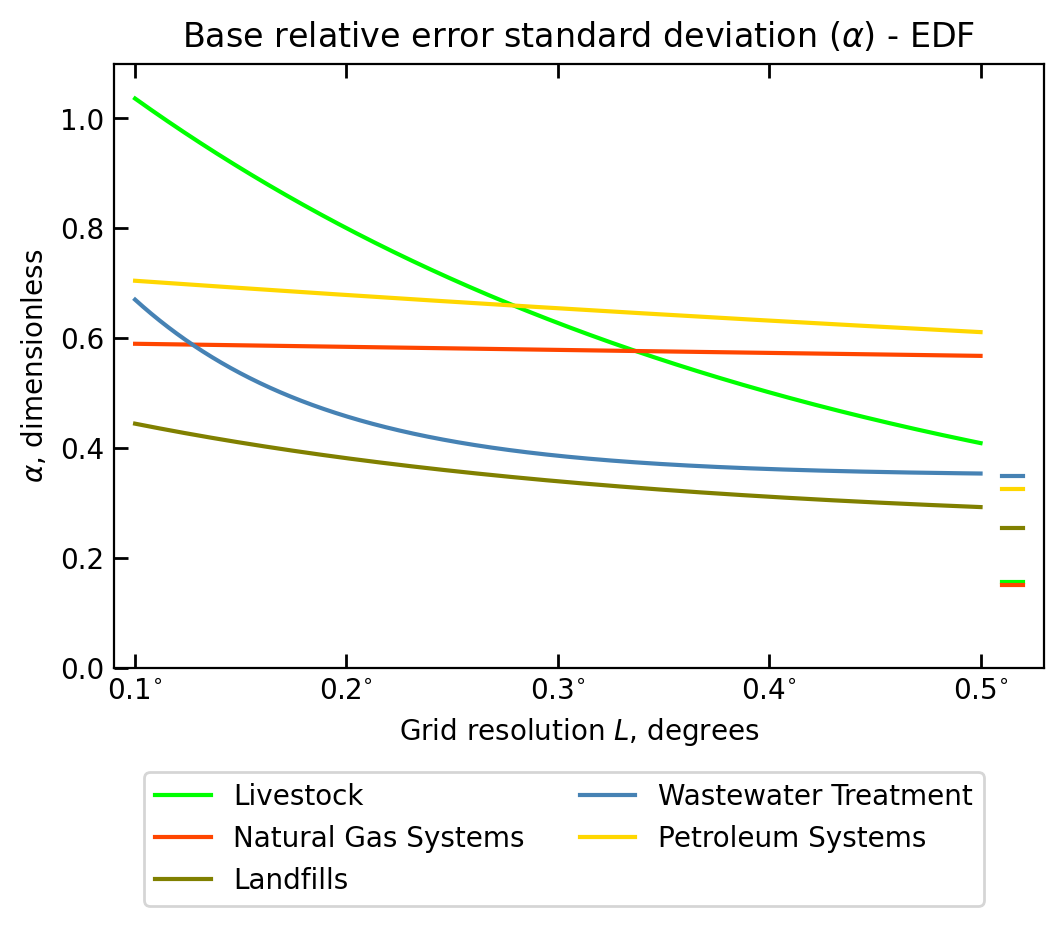

In [18]:
#Plot the error curves

plt.figure(dpi=200)
resol_plot = np.linspace(0.1,0.5,10000)
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_4AB[0],alph_par_4AB[1],alph_nat_4AB), label='Livestock',c='lime')
plt.plot([0.51,0.52], [alph_nat_4AB,alph_nat_4AB], c='lime')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_1B2b[0],alph_par_1B2b[1],alph_nat_1B2b), label='Natural Gas Systems', c='orangered')
plt.plot([0.51,0.52], [alph_nat_1B2b,alph_nat_1B2b], c='orangered')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_6A[0],alph_par_6A[1],alph_nat_6A), label='Landfills',c='olive')
plt.plot([0.51,0.52], [alph_nat_6A,alph_nat_6A], c='olive')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_6B[0],alph_par_6B[1],alph_nat_6B), label='Wastewater Treatment',c='steelblue')
plt.plot([0.51,0.52], [alph_nat_6B,alph_nat_6B], c='steelblue')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_1B2a[0],alph_par_1B2a[1],alph_nat_1B2a), label='Petroleum Systems',c='gold')
plt.plot([0.51,0.52], [alph_nat_1B2a,alph_nat_1B2a], c='gold')

plt.xlabel(r'Grid resolution $L$, degrees',fontsize=10)
plt.ylabel(r'$\alpha$, dimensionless',fontsize=10)
plt.title(r'Base relative error standard deviation ($\alpha$) - EDF',fontsize=12)
plt.tick_params(direction='in', length=5, width=1, which='major', colors='black', top='off')
plt.ylim([0,1.1])
plt.xlim([0.09,0.53])                                                      
plt.xticks(np.arange(0.1,0.6,0.1), ['0.1$^{\circ}$', '0.2$^{\circ}$', '0.3$^{\circ}$', '0.4$^{\circ}$','0.5$^{\circ}$'],fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.95, -0.15),ncol=2)
plt.show()

## CALGEM

In [19]:
# Files are in CH4:units = "nmol m^-2 s^-1" 
# - landfills (CALGEM_CH4_emissions_0.1_degree.LF.nc) 
# - dairy livestock (CALGEM_CH4_emissions_0.1_degree.DLS.nc)
# - non-dairy livestock (CALGEM_CH4_emissions_0.1_degree.NDLS.nc)
# - natural gas (CALGEM_CH4_emissions_0.1_degree.NG.nc) Note: the natural gas sector includes emissions from the natural gas system (production, processing, transmission and distribution) and petroleum production. See Jeong et al. (2016) and Jeong et al. (2014) for details.
# - wastewater (CALGEM_CH4_emissions_0.1_degree.WW.nc) 

#Read CALGEM lat/lon
temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.CP.nc')
CG_lat = np.array(temp_f.variables['lat'])
CG_lon = np.array(temp_f.variables['lon'])
temp_f.close()

CG_Total = np.zeros([len(CG_lat),len(CG_lon)])

#Initialze CALGEM
temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.DLS.nc')
CG_Livestock = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
temp_f.close()

temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.NDLS.nc')
CG_Livestock += np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_Livestock
temp_f.close()

temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.NG.nc')
CG_NGOil = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_NGOil
temp_f.close()

temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.WW.nc')
CG_WW = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_WW
temp_f.close()

temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.LF.nc')
CG_LF = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_LF
temp_f.close()

##Add other sectors to get to total
temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.CP.nc')
CG_Temp = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_Temp
temp_f.close()
temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.RM.nc')
CG_Temp = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_Temp
temp_f.close()
temp_f = Dataset('/Users/bramm/ownCloud2/GEPA2/Errors/Data_CALGEM/CALGEM_CH4_emissions_0.1_degree.LF.nc')
CG_Temp = np.array(temp_f.variables['ch4'])/float(10000)/float(10**9)*Avagrado
CG_Total += CG_Temp
temp_f.close()

In [20]:
#Define grid
Lat05 = np.arange(20.025,54.975+0.05,0.05)
Lon05 = np.arange(-129.975,-60.025+0.05,0.05)

#Regrid function
def regrid_05_EPA(inputarray):

    outputarray = np.zeros([len(Lat05),len(Lon05)])

    for i in np.arange(len(Lat)):
        for j in np.arange(len(Lon)):
            outputarray[i*2  ,j*2]   = inputarray[i,j]
            outputarray[i*2+1,j*2]   = inputarray[i,j]
            outputarray[i*2  ,j*2+1] = inputarray[i,j]
            outputarray[i*2+1,j*2+1] = inputarray[i,j]
            
    return(outputarray)

#Regrid function
def regrid_05_cg(inputarray, epa_array):

    inputarray  = inputarray[1:,1:]
    outputarray = np.zeros([len(Lat05),len(Lon05)])
    
    #Put CALGMEN on 0.05 grid.
       
    for i in np.arange(349):
        for j in np.arange(inputarray.shape[1]):
            epa_sum = epa_array[1+i*2  ,1+j*2]+epa_array[1+i*2+1,1+j*2]+epa_array[1+i*2  ,1+j*2+1]+epa_array[1+i*2+1,1+j*2+1]
            
            if epa_sum > 0:
                outputarray[1+i*2  ,1+j*2]   = inputarray[i,j]*epa_array[1+i*2  ,1+j*2]/float(epa_sum)*4
                outputarray[1+i*2+1,1+j*2]   = inputarray[i,j]*epa_array[1+i*2+1,1+j*2]/float(epa_sum)*4
                outputarray[1+i*2  ,1+j*2+1] = inputarray[i,j]*epa_array[1+i*2  ,1+j*2+1]/float(epa_sum)*4
                outputarray[1+i*2+1,1+j*2+1] = inputarray[i,j]*epa_array[1+i*2+1,1+j*2+1]/float(epa_sum)*4
            else:
                outputarray[1+i*2  ,1+j*2]   = inputarray[i,j]
                outputarray[1+i*2+1,1+j*2]   = inputarray[i,j]
                outputarray[1+i*2  ,1+j*2+1] = inputarray[i,j]
                outputarray[1+i*2+1,1+j*2+1] = inputarray[i,j]          

    return(outputarray)

#Regrid CALGEM
EPA05_1B2AB = regrid_05_EPA(EPA_v2_1B2a_Petroleum_Systems[:,:,0] + EPA_Gas[:,:,0])
CG05_1B2AB = regrid_05_cg(CG_NGOil,EPA05_1B2AB)

EPA05_4AB = regrid_05_EPA(EPA_v2_3A_Enteric_Fermentation[:,:,0] + EPA_v2_3B_Manure_Management[:,:,0])
CG05_4AB  = regrid_05_cg(CG_Livestock,EPA05_4AB)

EPA05_6A = regrid_05_EPA(EPA_v2_5A1_Landfills_Industrial[:,:,0] + EPA_v2_5A1_Landfills_MSW[:,:,0])
CG05_6A = regrid_05_cg(CG_LF,EPA05_6A)

EPA05_6B = regrid_05_EPA(EPA_v2_5D_Wastewater_Treatment_Domestic[:,:,0] + EPA_v2_5D_Wastewater_Treatment_Industrial[:,:,0])
EPA05_6B[EPA05_6B<0] = 0
CG05_6B = regrid_05_cg(CG_WW,EPA05_6B)

CG05_TOTAL = regrid_05_cg(CG_Total,np.ones(EPA05_4AB.shape))

In [21]:
#Create emission mask
CG05_MASK = np.zeros(CG05_TOTAL.shape)
CG05_MASK[CG05_TOTAL>0] = 1

In [22]:
def error_res_CG(EPA_in_05,CG_in_05,titlestring,national_alpha):
    
    CG_in = np.zeros([len(Lat),len(Lon)])
    EPA_in = np.zeros([len(Lat),len(Lon)])
    Mask_in = np.zeros([len(Lat),len(Lon)])

    for i in np.arange(len(Lat)):
        for j in np.arange(len(Lon)):
            CG_in[i,j] = np.mean(CG_in_05[i*2:(i+1)*2,j*2:(j+1)*2])
            EPA_in[i,j] = np.mean(EPA_in_05[i*2:(i+1)*2,j*2:(j+1)*2])     
            Mask_in[i,j] = np.mean(CG05_MASK[i*2:(i+1)*2,j*2:(j+1)*2])   
            
    Mask_in[Mask_in>0.5] = 1
    Mask_in[Mask_in<0.5] = 0
    
    print(' ')
    print(titlestring)
          
    Lon_2 = np.arange(-129.9,-60.1+0.2,0.2)
    Lat_2 = np.arange(20.1,54.9+0.2,0.2)
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); CG2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)):
        for j in np.arange(len(Lon_2)):
            CG2[i,j] = np.sum(CG_in[i*2:(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[i*2:(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,j*2:(j+1)*2])
            FLA2[i,j] = np.sum(Mask_in[i*2:(i+1)*2,j*2:(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1    
    
    print('.2')
    err_two_1 = cost_explore(EPA2,CG2,FLA2,titlestring,national_alpha,0.2)
    
    
    #2
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); CG2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            CG2[i,j] = np.sum(CG_in[1+i*2:1+(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[1+i*2:1+(i+1)*2,j*2:(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,j*2:(j+1)*2])
            FLA2[i,j] = np.sum(Mask_in[1+i*2:1+(i+1)*2,j*2:(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1
    
    err_two_2 = cost_explore(EPA2,CG2,FLA2,titlestring,national_alpha,0.2)
 
    #3
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); CG2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            CG2[i,j] = np.sum(CG_in[i*2:(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[i*2:(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[i*2:(i+1)*2,1+j*2:1+(j+1)*2])
            FLA2[i,j] = np.sum(Mask_in[i*2:(i+1)*2,1+j*2:1+(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1   
    
    err_two_3 = cost_explore(EPA2,CG2,FLA2,titlestring,national_alpha,0.2)
    
    #4
    FLA2 = np.zeros([len(Lat_2),len(Lon_2)]); CG2 = np.zeros([len(Lat_2),len(Lon_2)]); EPA2 = np.zeros([len(Lat_2),len(Lon_2)]) 
    
    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            CG2[i,j] = np.sum(CG_in[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])
            EPA2[i,j] = np.sum(EPA_in[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2]*area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])/np.sum(area_matrix_km2[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])
            FLA2[i,j] = np.sum(Mask_in[1+i*2:1+(i+1)*2,1+j*2:1+(j+1)*2])

    FLA2[FLA2 < 1] = 0; FLA2[FLA2 > 0] = 1   
    
    err_two_4 = cost_explore(EPA2,CG2,FLA2,titlestring,national_alpha,0.2)
    
    #1
    Lon_3 = np.arange(-129.85,-60.15+0.3,0.3)
    Lat_3 = np.arange(20.15,54.85+0.3,0.3)
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); CG3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            CG3[i,j] = np.sum(CG_in[i*3:(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[i*3:(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,j*3:(j+1)*3])
            FLA3[i,j] = np.sum(Mask_in[i*3:(i+1)*3,j*3:(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    print('.3')
    err_thr_1 = cost_explore(EPA3,CG3,FLA3,titlestring,national_alpha,0.3)
    
    #2
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); CG3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            CG3[i,j] = np.sum(CG_in[1+i*3:1+(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[1+i*3:1+(i+1)*3,j*3:(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,j*3:(j+1)*3])
            FLA3[i,j] = np.sum(Mask_in[1+i*3:1+(i+1)*3,j*3:(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    err_thr_2 = cost_explore(EPA3,CG3,FLA3,titlestring,national_alpha,0.3)    
  
    #3
    Lon_3 = np.arange(-129.85,-60.15+0.3,0.3)
    Lat_3 = np.arange(20.15,54.85+0.3,0.3)
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); CG3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            CG3[i,j] = np.sum(CG_in[i*3:(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[i*3:(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[i*3:(i+1)*3,1+j*3:1+(j+1)*3])
            FLA3[i,j] = np.sum(Mask_in[i*3:(i+1)*3,1+j*3:1+(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    err_thr_3 = cost_explore(EPA3,CG3,FLA3,titlestring,national_alpha,0.3)
    
    #4
    FLA3 = np.zeros([len(Lat_3),len(Lon_3)]); CG3 = np.zeros([len(Lat_3),len(Lon_3)]); EPA3 = np.zeros([len(Lat_3),len(Lon_3)]) 
    
    for i in np.arange(len(Lat_3)-1):
        for j in np.arange(len(Lon_3)-1):
            CG3[i,j] = np.sum(CG_in[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])
            EPA3[i,j] = np.sum(EPA_in[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3]*area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])/np.sum(area_matrix_km2[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])
            FLA3[i,j] = np.sum(Mask_in[1+i*3:1+(i+1)*3,1+j*3:1+(j+1)*3])

    FLA3[FLA3 < 2.25] = 0; FLA3[FLA3 > 2.25] = 1
    
    err_thr_4 = cost_explore(EPA3,CG3,FLA3,titlestring,national_alpha,0.3)        
      
    
    
    Lon_4 = np.arange(-129.8,-60.2+0.4,0.4)
    Lat_4 = np.arange(20.2,54.8+0.4,0.4)
    
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); CG4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)):
        for j in np.arange(len(Lon_4)):
            CG4[i,j] = np.sum(CG_in[i*4:(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[i*4:(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,j*4:(j+1)*4])
            FLA4[i,j] = np.sum(Mask_in[i*4:(i+1)*4,j*4:(j+1)*4])
 
    FLA4[FLA4 < 4] = 0; FLA4[FLA4 > 0] = 1     
    
    print('.4')
    err_four_1 = cost_explore(EPA4,CG4,FLA4,titlestring,national_alpha,0.4)
    
    #2
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); CG4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)-1):
        for j in np.arange(len(Lon_4)-1):
            CG4[i,j] = np.sum(CG_in[i*4:(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[i*4:(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[i*4:(i+1)*4,1+j*4:1+(j+1)*4])
            FLA4[i,j] = np.sum(Mask_in[i*4:(i+1)*4,1+j*4:1+(j+1)*4])
 
    FLA4[FLA4 < 4] = 0
    FLA4[FLA4 > 0] = 1
    
    err_four_2 = cost_explore(EPA4,CG4,FLA4,titlestring,national_alpha,0.4)
    
    #3
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); CG4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)-1):
        for j in np.arange(len(Lon_4)-1):
            CG4[i,j] = np.sum(CG_in[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])
            FLA4[i,j] = np.sum(Mask_in[1+i*4:1+(i+1)*4,1+j*4:1+(j+1)*4])
 
    FLA4[FLA4 < 4] = 0
    FLA4[FLA4 > 0] = 1
    
    err_four_3 = cost_explore(EPA4,CG4,FLA4,titlestring,national_alpha,0.4)
    
    #4   
    FLA4 = np.zeros([len(Lat_4),len(Lon_4)]); CG4 = np.zeros([len(Lat_4),len(Lon_4)]); EPA4 = np.zeros([len(Lat_4),len(Lon_4)]) 
 
    for i in np.arange(len(Lat_4)-1):
        for j in np.arange(len(Lon_4)-1):
            CG4[i,j] = np.sum(CG_in[1+i*4:1+(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])
            EPA4[i,j] = np.sum(EPA_in[1+i*4:1+(i+1)*4,j*4:(j+1)*4]*area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])/np.sum(area_matrix_km2[1+i*4:1+(i+1)*4,j*4:(j+1)*4])
            FLA4[i,j] = np.sum(Mask_in[1+i*4:1+(i+1)*4,j*4:(j+1)*4])
 
    FLA4[FLA4 < 4] = 0
    FLA4[FLA4 > 0] = 1
    
    err_four_4 = cost_explore(EPA4,CG4,FLA4,titlestring,national_alpha,0.4)
    
    
    #1
    Lon_5 = np.arange(-129.75,-60.25+0.5,0.5)
    Lat_5 = np.arange(20.25,54.75+0.5,0.5)
    
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); CG5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 
 
    for i in np.arange(len(Lat_5)):
        for j in np.arange(len(Lon_5)):
            CG5[i,j] = np.sum(CG_in[i*5:(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[i*5:(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,j*5:(j+1)*5])
            FLA5[i,j] = np.sum(Mask_in[i*5:(i+1)*5,j*5:(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
    
    print('.5')
    err_five_1 = cost_explore(EPA5,CG5,FLA5,titlestring,national_alpha,0.5)
  
    #2
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); CG5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 
 
    for i in np.arange(len(Lat_5)-1):
        for j in np.arange(len(Lon_5)-1):
            CG5[i,j] = np.sum(CG_in[i*5:(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[i*5:(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[i*5:(i+1)*5,1+j*5:1+(j+1)*5])
            FLA5[i,j] = np.sum(Mask_in[i*5:(i+1)*5,1+j*5:1+(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
        
    err_five_2 = cost_explore(EPA5,CG5,FLA5,titlestring,national_alpha,0.5)
    
    #3
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); CG5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 

    for i in np.arange(len(Lat_5)-1):
        for j in np.arange(len(Lon_5)-1):
            CG5[i,j] = np.sum(CG_in[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])
            FLA5[i,j] = np.sum(Mask_in[1+i*5:1+(i+1)*5,1+j*5:1+(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
       
    err_five_3 = cost_explore(EPA5,CG5,FLA5,titlestring,national_alpha,0.5)
    
    #4
    FLA5 = np.zeros([len(Lat_5),len(Lon_5)]); CG5 = np.zeros([len(Lat_5),len(Lon_5)]); EPA5 = np.zeros([len(Lat_5),len(Lon_5)]) 
 
    for i in np.arange(len(Lat_5)-1):
        for j in np.arange(len(Lon_5)-1):
            CG5[i,j] = np.sum(CG_in[1+i*5:1+(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])
            EPA5[i,j] = np.sum(EPA_in[1+i*5:1+(i+1)*5,j*5:(j+1)*5]*area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])/np.sum(area_matrix_km2[1+i*5:1+(i+1)*5,j*5:(j+1)*5])
            FLA5[i,j] = np.sum(Mask_in[1+i*5:1+(i+1)*5,j*5:(j+1)*5])
 
    FLA5[FLA5 < 6.25] = 0
    FLA5[FLA5 > 0] = 1
    
    err_five_4 = cost_explore(EPA5,CG5,FLA5,titlestring,national_alpha,0.5)
    
    resol   = np.array([0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5])
    err_alph = np.array([err_two_1,err_two_2,err_two_3,err_two_4,err_thr_1,err_thr_2,err_thr_3,err_thr_4,err_four_1,err_four_2,err_four_3,err_four_4,err_five_1,err_five_2,err_five_3,err_five_4])

    return(resol,err_alph)

In [23]:
print('Analyze errors for multiple resolutions with basic cost function')
resol_CG, alph_1B2ab_CG  = error_res_CG(EPA05_1B2AB,CG05_1B2AB, 'O/G systems', alph_nat_1B2ab)
resol_CG, alph_4AB_CG    = error_res_CG(EPA05_4AB,  CG05_4AB,   'Livestock',   alph_nat_4AB)
resol_CG, alph_6A_CG     = error_res_CG(EPA05_6A,   CG05_6A,    'Landfills',   alph_nat_6A)
resol_CG, alph_6B_CG     = error_res_CG(EPA05_6B,   CG05_6B,    'Wastewater',  alph_nat_6B)

Analyze errors for multiple resolutions with basic cost function
 
O/G systems
.2
Scaling:  0.7659833971902943
Scaling:  0.7559833971902943
Scaling:  0.7459833971902943
Scaling:  0.7559833971902943
.3
Scaling:  0.7659833971902943
Scaling:  0.7759833971902943
Scaling:  0.7559833971902943
Scaling:  0.7459833971902943
.4
Scaling:  0.7959833971902943
Scaling:  0.7759833971902943
Scaling:  0.8059833971902943
Scaling:  0.8159833971902943
.5
Scaling:  0.7659833971902943
Scaling:  0.7459833971902943
Scaling:  0.7859833971902943
Scaling:  0.8159833971902943
 
Livestock
.2
Scaling:  0.9366003134796246
Scaling:  0.9866003134796246
Scaling:  1.0066003134796246
Scaling:  1.0066003134796246
.3
Scaling:  0.8266003134796245
Scaling:  0.8866003134796245
Scaling:  0.9866003134796246
Scaling:  0.9566003134796246
.4
Scaling:  0.8266003134796245
Scaling:  0.9266003134796246
Scaling:  0.9266003134796246
Scaling:  0.8166003134796245
.5
Scaling:  0.8466003134796245
Scaling:  0.7566003134796244
Scaling:  0.656

In [24]:
resol_s_CG = np.array([np.mean(resol_CG[0:4]),np.mean(resol_CG[4:8]),np.mean(resol_CG[8:12]),np.mean(resol_CG[12])])
alph_1B2ab_s_CG = np.array([np.mean(alph_1B2ab_CG[0:4]),np.mean(alph_1B2ab_CG[4:8]),np.mean(alph_1B2ab_CG[8:12]),np.mean(alph_1B2ab_CG[12:])])
alph_4AB_s_CG = np.array([np.mean(alph_4AB_CG[0:4]),np.mean(alph_4AB_CG[4:8]),np.mean(alph_4AB_CG[8:12]),np.mean(alph_4AB_CG[12:])])
alph_6A_s_CG = np.array([np.mean(alph_6A_CG[0:4]),np.mean(alph_6A_CG[4:8]),np.mean(alph_6A_CG[8:12]),np.mean(alph_6A_CG[12:])])
alph_6B_s_CG = np.array([np.mean(alph_6B_CG[0:4]),np.mean(alph_6B_CG[4:8]),np.mean(alph_6B_CG[8:12]),np.mean(alph_6B_CG[12:])])

alph_national = alph_nat_1B2ab
alph_par_1B2ab_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_1B2ab_s_CG)[0]
print('Petroleum / Natural Gas - Alpha', alph_par_1B2ab_CG[0:])

alph_national = alph_nat_4AB
alph_par_4AB_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_4AB_s_CG)[0]
print('Livestock - Alpha', alph_par_4AB_CG[0:])

alph_national = alph_nat_6A
alph_par_6A_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_6A_s_CG)[0]
print('Landfills - Alpha', alph_par_6A_CG[0:])

alph_national = alph_nat_6B
alph_par_6B_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_6B_s_CG)[0]
print( 'Wastewater - Alpha', alph_par_6B_CG[0:])

Petroleum / Natural Gas - Alpha [5.88548229e-01 1.12383603e-08]
Livestock - Alpha [0.91027652 0.89938287]
Landfills - Alpha [ 0.27314602 15.2114986 ]
Wastewater - Alpha [0.99931329 2.54386501]


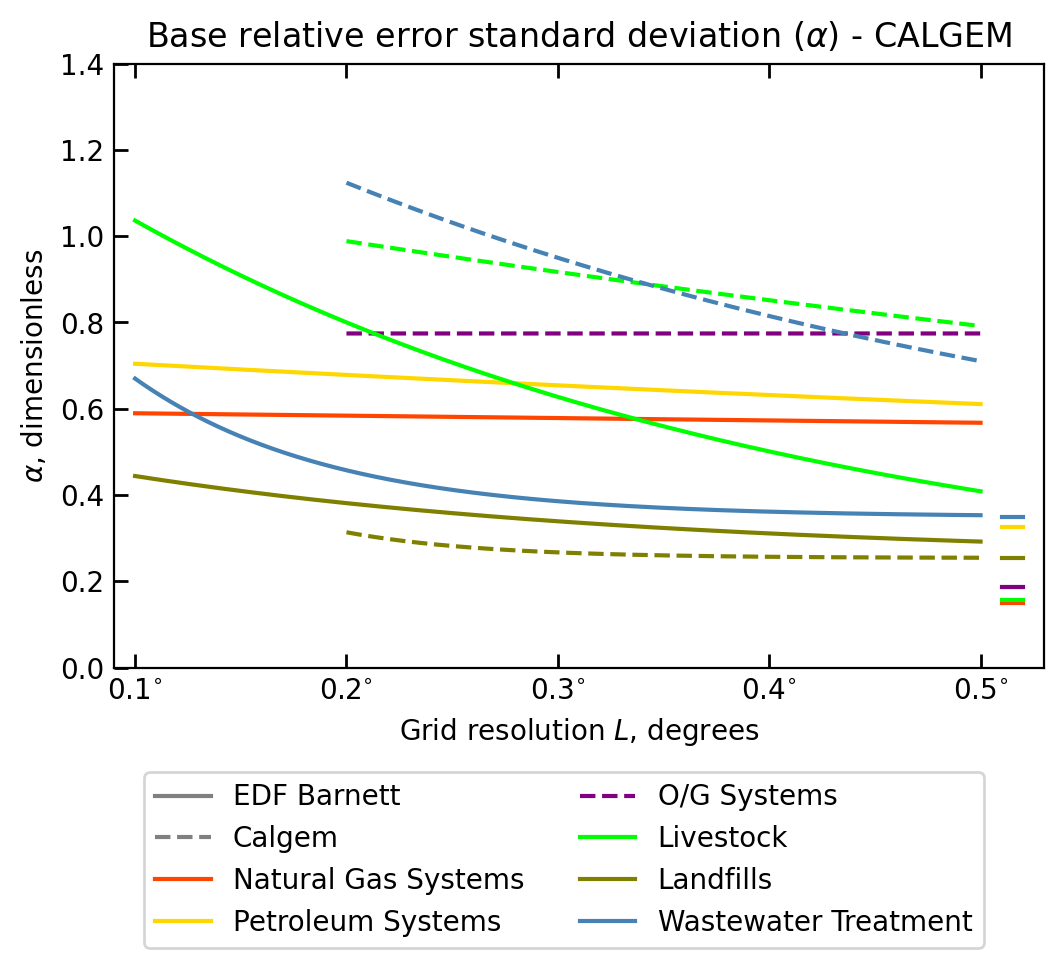

In [25]:
#Plot results also comparing with EDF.

plt.figure(dpi=200)
resol_plot = np.linspace(0.1,0.5,10000)
resol_plot_CG = np.linspace(0.2,0.5,10000)

plt.plot(resol_plot,-10*resol_plot,label='EDF Barnett',c='grey')
plt.plot(resol_plot,-10*resol_plot,'--', label='Calgem',c='grey')


plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_1B2b[0],alph_par_1B2b[1],alph_nat_1B2b), label='Natural Gas Systems', c='orangered')
plt.plot([0.51,0.52], [alph_nat_1B2b,alph_nat_1B2b], c='orangered')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_1B2a[0],alph_par_1B2a[1],alph_nat_1B2a), label='Petroleum Systems',c='gold')
plt.plot([0.51,0.52], [alph_nat_1B2a,alph_nat_1B2a], c='gold')
plt.plot(resol_plot_CG,Alph_function_p(resol_plot_CG,alph_par_1B2ab_CG[0],alph_par_1B2ab_CG[1],alph_nat_1B2ab), '--', label='O/G Systems', c='purple')
plt.plot([0.51,0.52], [alph_nat_1B2ab,alph_nat_1B2ab], c='purple')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_4AB[0],alph_par_4AB[1],alph_nat_4AB), label='Livestock',c='lime')
plt.plot([0.51,0.52], [alph_nat_4AB,alph_nat_4AB], c='lime')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_6A[0],alph_par_6A[1],alph_nat_6A), label='Landfills',c='olive')
plt.plot([0.51,0.52], [alph_nat_6A,alph_nat_6A], c='olive')
plt.plot(resol_plot,Alph_function_p(resol_plot,alph_par_6B[0],alph_par_6B[1],alph_nat_6B), label='Wastewater Treatment',c='steelblue')
plt.plot([0.51,0.52], [alph_nat_6B,alph_nat_6B], c='steelblue')

resol_plot_CG = np.linspace(0.2,0.5,10000)
plt.plot(resol_plot_CG,Alph_function_p(resol_plot_CG,alph_par_4AB_CG[0],alph_par_4AB_CG[1],alph_nat_4AB), '--',c='lime')
plt.plot(resol_plot_CG,Alph_function_p(resol_plot_CG,alph_par_6A_CG[0],alph_par_6A_CG[1],alph_nat_6A),'--', c='olive')
plt.plot(resol_plot_CG,Alph_function_p(resol_plot_CG,alph_par_6B_CG[0],alph_par_6B_CG[1],alph_nat_6B),'--', c='steelblue')

plt.xlabel(r'Grid resolution $L$, degrees',fontsize=10)
plt.ylabel(r'$\alpha$, dimensionless',fontsize=10)
plt.title(r'Base relative error standard deviation ($\alpha$) - CALGEM',fontsize=12)
plt.tick_params(direction='in', length=5, width=1, which='major', colors='black', top='off')
plt.ylim([0,1.4])
plt.xlim([0.09,0.53])                                                      
plt.xticks(np.arange(0.1,0.6,0.1), ['0.1$^{\circ}$', '0.2$^{\circ}$', '0.3$^{\circ}$', '0.4$^{\circ}$','0.5$^{\circ}$'],fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.95, -0.15),ncol=2)
plt.show()

In [26]:
def budg_calc(EPA_in,CG_in):
    CG_01 = np.zeros([len(Lat),len(Lon)])
    EPA_01 = np.zeros([len(Lat),len(Lon)])
    CGMASK_01 = np.zeros([len(Lat),len(Lon)])

    for i in np.arange(len(Lat)):
        for j in np.arange(len(Lon)):
            CG_01[i,j] = np.mean(CG_in[i*2:(i+1)*2,j*2:(j+1)*2])
            EPA_01[i,j] = np.mean(EPA_in[i*2:(i+1)*2,j*2:(j+1)*2])
            CGMASK_01[i,j] = np.mean(CG05_MASK[i*2:(i+1)*2,j*2:(j+1)*2])
                
    CGMASK_01[CGMASK_01>0.5] = 1
    CGMASK_01[CGMASK_01<0.5] = 0
            
    CG_tg = CG_01 / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix
    EPA_tg = EPA_01 / float(10**12 * Avagrado) * Molarch4 * 366 * 24 * 60 * 60 * area_matrix
  
    print('CG:    ', np.sum(CG_tg)*1000, ' EPA: ', np.sum(EPA_tg[CGMASK_01 > 0])*1000)
    
    #Get rid of Oregon / Arizona
    CG_tg[(CGMASK_01 == 0)] = 0
    EPA_tg[(CGMASK_01 == 0)] = 0
    
    Lon_2 = np.arange(-129.9,-60.1+0.2,0.2)
    Lat_2 = np.arange(20.1,54.9+0.2,0.2)
    
    CG_02 = np.zeros([len(Lat_2),len(Lon_2)]) 
    EPA_02 = np.zeros([len(Lat_2),len(Lon_2)]) 
    CF_02 = np.zeros([len(Lat_2),len(Lon_2)]) 

    for i in np.arange(len(Lat_2)-1):
        for j in np.arange(len(Lon_2)-1):
            CG_02[i,j] =  np.sum(CG_tg[ i*2:(i+1)*2,j*2:(j+1)*2])
            EPA_02[i,j] = np.sum(EPA_tg[i*2:(i+1)*2,j*2:(j+1)*2])
            CF_02[i,j] = np.sum(CGMASK_01[i*2:(i+1)*2,j*2:(j+1)*2])
   
    
    print('Correlation EPA:  ', np.corrcoef(EPA_02[CF_02 > 1],CG_02[CF_02 > 1])[0,1])
    
print('OG')
budg_calc(EPA05_1B2AB,CG05_1B2AB)
print('Livestock')
budg_calc(EPA05_4AB,CG05_4AB)
print('Landfills')
budg_calc(EPA05_6A,CG05_6A)
print('Wastewater')
budg_calc(EPA05_6B,CG05_6B)
print('All')
budg_calc(EPA05_1B2AB+EPA05_4AB+EPA05_6A+EPA05_6B,CG05_1B2AB+CG05_4AB+CG05_6A+CG05_6B)

OG
CG:     284.37805208064174  EPA:  233.97501043733715
Correlation EPA:   0.5821068219772827
Livestock
CG:     899.3159136338721  EPA:  843.0090727418235
Correlation EPA:   0.47193535821357246
Landfills
CG:     336.7381709960599  EPA:  433.9801812763298
Correlation EPA:   0.9236053844492754
Wastewater
CG:     67.31960466381904  EPA:  40.56341389142116
Correlation EPA:   0.6590861214668811
All
CG:     1587.7517413743929  EPA:  1551.5276783469117
Correlation EPA:   0.640974468098745


## Scaled CALGEM

In [27]:
#Scale so large-scale budget mismatches don't mess up the error curves

CG05_1B2AB_s = CG05_1B2AB * 233.97501043733715 / 284.3806678305171
CG05_4AB_s   = CG05_4AB * 843.0090727418235 / 899.3159136338721
CG05_6A_s    = CG05_6A * 433.9801811932428 / 336.7381709962495
CG05_6B_s    = CG05_6B * 40.56341389142116 / 67.31896399866321

In [28]:
print('Analyze errors for multiple resolutions with basic cost function')
resol_CG, alph_1B2ab_CG  = error_res_CG(EPA05_1B2AB,CG05_1B2AB_s, 'O/G systems', alph_nat_1B2ab)
resol_CG, alph_4AB_CG    = error_res_CG(EPA05_4AB,  CG05_4AB_s,   'Livestock',   alph_nat_4AB)
resol_CG, alph_6A_CG     = error_res_CG(EPA05_6A,   CG05_6A_s,    'Landfills',   alph_nat_6A)
resol_CG, alph_6B_CG     = error_res_CG(EPA05_6B,   CG05_6B_s,    'Wastewater',  alph_nat_6B)

Analyze errors for multiple resolutions with basic cost function
 
O/G systems
.2
Scaling:  0.7659833971902943
Scaling:  0.7659833971902943
Scaling:  0.7659833971902943
Scaling:  0.7659833971902943
.3
Scaling:  0.7659833971902943
Scaling:  0.7759833971902943
Scaling:  0.7659833971902943
Scaling:  0.7559833971902943
.4
Scaling:  0.7759833971902943
Scaling:  0.7759833971902943
Scaling:  0.7859833971902943
Scaling:  0.7959833971902943
.5
Scaling:  0.7559833971902943
Scaling:  0.7459833971902943
Scaling:  0.7759833971902943
Scaling:  0.7859833971902943
 
Livestock
.2
Scaling:  0.9166003134796246
Scaling:  0.9566003134796246
Scaling:  0.9766003134796246
Scaling:  0.9866003134796246
.3
Scaling:  0.8066003134796245
Scaling:  0.8566003134796245
Scaling:  0.9466003134796246
Scaling:  0.9266003134796246
.4
Scaling:  0.7966003134796245
Scaling:  0.8866003134796245
Scaling:  0.8866003134796245
Scaling:  0.7966003134796245
.5
Scaling:  0.8066003134796245
Scaling:  0.7166003134796244
Scaling:  0.606

In [29]:
resol_s_CG = np.array([np.mean(resol_CG[0:4]),np.mean(resol_CG[4:8]),np.mean(resol_CG[8:12]),np.mean(resol_CG[12])])
alph_1B2ab_s_CG = np.array([np.mean(alph_1B2ab_CG[0:4]),np.mean(alph_1B2ab_CG[4:8]),np.mean(alph_1B2ab_CG[8:12]),np.mean(alph_1B2ab_CG[12:])])
alph_4AB_s_CG = np.array([np.mean(alph_4AB_CG[0:4]),np.mean(alph_4AB_CG[4:8]),np.mean(alph_4AB_CG[8:12]),np.mean(alph_4AB_CG[12:])])
alph_6A_s_CG = np.array([np.mean(alph_6A_CG[0:4]),np.mean(alph_6A_CG[4:8]),np.mean(alph_6A_CG[8:12]),np.mean(alph_6A_CG[12:])])
alph_6B_s_CG = np.array([np.mean(alph_6B_CG[0:4]),np.mean(alph_6B_CG[4:8]),np.mean(alph_6B_CG[8:12]),np.mean(alph_6B_CG[12:])])

alph_national = alph_nat_1B2ab
alph_par_1B2ab_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_1B2ab_s_CG)[0]
print('Petroleum / Natural Gas - Alpha', alph_par_1B2ab_CG[0:])

alph_national = alph_nat_4AB
alph_par_4AB_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_4AB_s_CG)[0]
print('Livestock - Alpha', alph_par_4AB_CG[0:])

alph_national = alph_nat_6A
alph_par_6A_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_6A_s_CG)[0]
print('Landfills - Alpha', alph_par_6A_CG[0:])

alph_national = alph_nat_6B
alph_par_6B_CG = sp.optimize.curve_fit(Alph_function,resol_s_CG,alph_6B_s_CG)[0]
print( 'Wastewater - Alpha', alph_par_6B_CG[0:])

Petroleum / Natural Gas - Alpha [5.84201227e-01 1.09830944e-07]
Livestock - Alpha [0.89459551 1.01740114]
Landfills - Alpha [0.09908935 5.86279923]
Wastewater - Alpha [0.64278269 5.81299011]


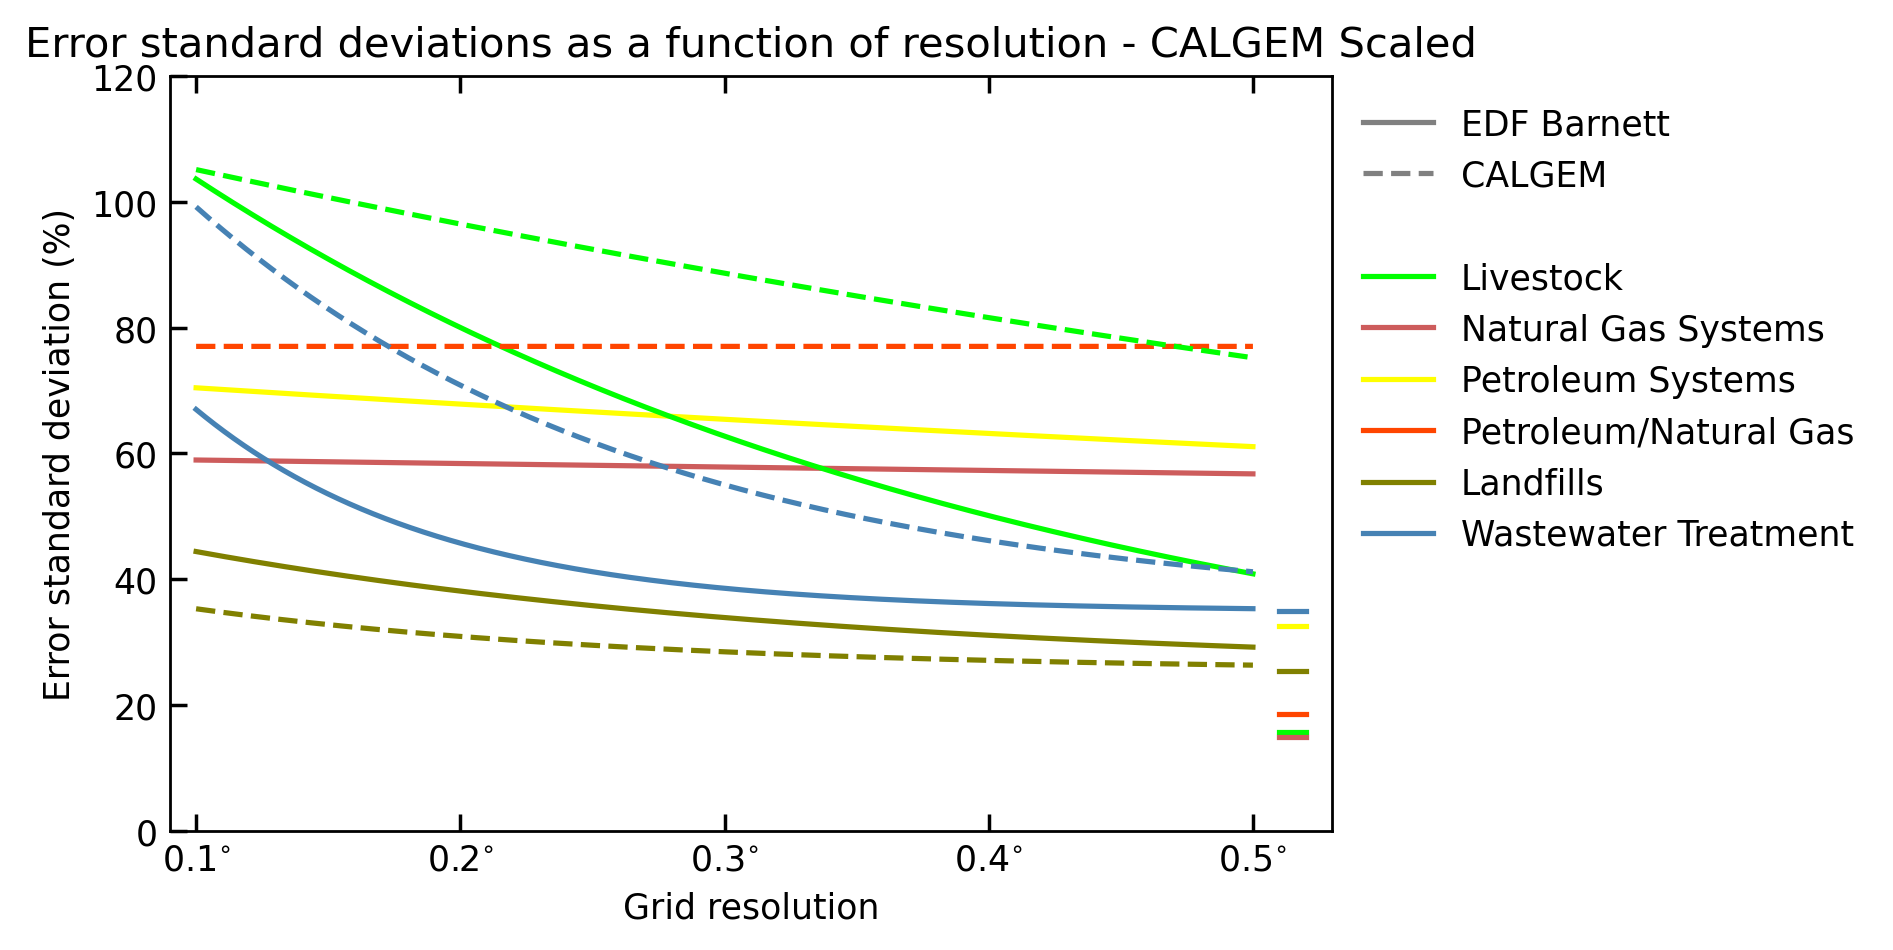

In [30]:
plt.figure(dpi=250)
resol_plot = np.linspace(0.1,0.5,10000)

plt.plot(resol_plot,-10*resol_plot,label='EDF Barnett',c='grey')
plt.plot(resol_plot,-10*resol_plot,'--', label='CALGEM',c='grey')
plt.plot(resol_plot,-10*resol_plot,'--', label=' ',c='white')

plt.plot([0.51,0.52], [100* alph_nat_4AB,100* alph_nat_4AB], c='lime', label='Livestock')
plt.plot([0.51,0.52], [100*alph_nat_1B2b,100*alph_nat_1B2b], c='indianred', label='Natural Gas Systems')
plt.plot([0.51,0.52],[100* alph_nat_1B2a,100* alph_nat_1B2a], c='yellow', label='Petroleum Systems')
plt.plot([0.51,0.52], [100* alph_nat_1B2ab,100* alph_nat_1B2ab], c='orangered',label='Petroleum/Natural Gas')
plt.plot([0.51,0.52], [100* alph_nat_6A,100* alph_nat_6A], c='olive', label='Landfills')
plt.plot([0.51,0.52], [100* alph_nat_6B,100* alph_nat_6B], c='steelblue', label='Wastewater Treatment')

plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_1B2b[0],alph_par_1B2b[1],alph_nat_1B2b), c='indianred')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_1B2a[0],alph_par_1B2a[1],alph_nat_1B2a),c='yellow')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_4AB[0],alph_par_4AB[1],alph_nat_4AB),c='lime')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_6A[0],alph_par_6A[1],alph_nat_6A),c='olive')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_6B[0],alph_par_6B[1],alph_nat_6B),c='steelblue')

plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_1B2ab_CG[0],alph_par_1B2ab_CG[1],alph_nat_1B2ab), '--',  c='orangered')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_4AB_CG[0],alph_par_4AB_CG[1],alph_nat_4AB), '--',c='lime')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_6A_CG[0],alph_par_6A_CG[1],alph_nat_6A),'--', c='olive')
plt.plot(resol_plot,100*Alph_function_p(resol_plot,alph_par_6B_CG[0],alph_par_6B_CG[1],alph_nat_6B),'--', c='steelblue')

plt.xlabel(r'Grid resolution',fontsize=10)
plt.ylabel(r'Error standard deviation (%)',fontsize=10)
plt.title(r'Error standard deviations as a function of resolution - CALGEM Scaled',fontsize=12)
plt.tick_params(direction='in', length=5, width=1, which='major', colors='black', top='off')
plt.ylim([0,120])
plt.xlim([0.09,0.53])                                                      
plt.xticks(np.arange(0.1,0.6,0.1), ['0.1$^{\circ}$', '0.2$^{\circ}$', '0.3$^{\circ}$', '0.4$^{\circ}$','0.5$^{\circ}$'],fontsize=10)
plt.yticks(fontsize=10)
#plt.legend(bbox_to_anchor=(1.2, -0.15),ncol=3,frameon=False)
plt.legend(bbox_to_anchor=(1, 1),ncol=1,frameon=False)
plt.show()

## New York

In [46]:
are_f = Dataset('Data_NY/gridded_NYS_methane_2020.nc4')
NY_Lon_crs = np.array(are_f.variables['x'])
NY_Lat_crs = np.array(are_f.variables['y'])
are_f.close()

from pyproj import CRS, Transformer

crs26 = CRS.from_epsg(26918)
proj = Transformer.from_crs(crs26, CRS.from_epsg(4326),)
#proj = Transformer.from_crs("EPSG:26918","EPSG:4326")

In [45]:
print(np.array(proj.transform(NY_Lon_crs[0],NY_Lat_crs[0])))
print(np.array(proj.transform(NY_Lon_crs[-1],NY_Lat_crs[-1])))

[ 40.37744483 -79.65178062]
[ 44.97178402 -71.44977226]
